 по ссылкам ниже интересные материалы по А/В тестам  
    
https://habr.com/ru/company/avito/blog/571094/

https://habr.com/ru/company/yandex/blog/476826/

https://academy.yandex.ru/journal/kak-provesti-a-b-testirovanie-6-prostykh-shagov

https://habr.com/ru/company/yandex/blog/342704/

https://r-analytics.blogspot.com/2013/10/blog-post_13.html 


# Принятие решений в бизнесе
**Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.**


In [1]:
 # импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
import seaborn as sns
import scipy.stats as stats

In [2]:
# чтение файла с данными и сохранение в датафреймы

hyp = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
# просмотр информации о таблицах и проверка наличия дубликатов
d = {'hypothesis' : hyp, 'orders' : orders, 'visitors' : visitors}
for a, i in d.items():
    print(f'Название датафрейма {a}, количество дубликатов {i.duplicated().sum()}')
    display(i.head())
    display(i.info())
    print('- ' * 50)

Название датафрейма hypothesis, количество дубликатов 0


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Название датафрейма orders, количество дубликатов 0


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Название датафрейма visitors, количество дубликатов 0


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


 Согласно документации к данным:
1. Таблица hypothesis.csv содержит данные о гипотезах:

    Hypothesis — краткое описание гипотезы;

    Reach — охват пользователей по 10-балльной шкале;

    Impact — влияние на пользователей по 10-балльной шкале;

    Confidence — уверенность в гипотезе по 10-балльной шкале;

    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


2. Таблица  orders.csv содержит данные о заказах в период проведения A/B теста:

    transactionId — идентификатор заказа;

    visitorId — идентификатор пользователя, совершившего заказ;

    date — дата, когда был совершён заказ;

    revenue — выручка заказа;

    group — группа A/B-теста, в которую попал заказ.
    

3. Таблица visitors.csv содержит данные о посетителях сайта в период A/B теста:

    date — дата;

    group — группа A/B-теста;

    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

Пропусков в данных нет, но названия столбцов не соответствуют snake case. Исправим это.

In [4]:
hyp.columns = [x.lower() for x in hyp.columns.values]
orders.columns = [x.replace('Id', '_id') for x in orders.columns.values]

In [5]:
# преобразование данных о времени
orders['date'] = pd.to_datetime(orders['date']).dt.date
visitors['date'] = pd.to_datetime(visitors['date']).dt.date

 Данные к анализу подготовлены.

# Часть 1. Приоритизация гипотез.
**В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.**

## Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [6]:
hyp['ICE'] = hyp.impact * hyp.confidence / hyp.efforts

hyp[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


## Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [7]:
hyp['RICE'] = hyp.reach * hyp.impact * hyp.confidence / hyp.efforts

hyp[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


In [8]:
 # визуализируем изменение порядка гипотез
t_ICE = hyp[['hypothesis', 'ICE']].sort_values(by='ICE').reset_index(drop=True).reset_index().drop('ICE', axis=1)
t_RICE = hyp[['hypothesis', 'RICE']].sort_values(by='RICE').reset_index(drop=True).reset_index().drop('RICE', axis=1)
t_all = t_ICE.merge(t_RICE, on='hypothesis')
t_all = t_all.set_axis(['ICE', 'hypothesis', 'RICE'], axis=1)

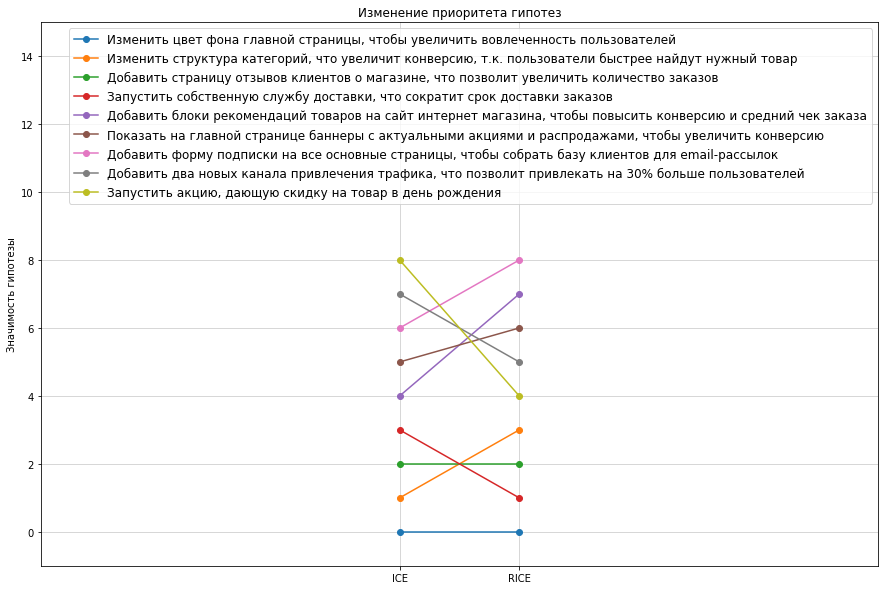

In [9]:
 fig, ax = plt.subplots(figsize=(15, 10))

for i in hyp.index:
    ax.plot(t_all.iloc[i, [0, 2]], marker ='o', label=f'{t_all.iloc[i, 1]}')
plt.ylabel('Значимость гипотезы')
plt.ylim(-1, 15)
plt.xlim(-3, 4)
plt.grid(linestyle='-', linewidth=0.5)
plt.legend(loc='upper right', fontsize='large')
plt.title('Изменение приоритета гипотез')
plt.show()

 ## Вывод:
 
При обоих методах в лидерах гипотезы 7 и 0 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"
, при том, что форму подписки на основных страницах увидят почти все посетители сайта, а новые каналы трафика, вероятно, 30% пользователей.

Гипотеза "Запустить акцию, дающую скидку на товар в день рождения", несмотря на то, что затрагивает вроде бы всех пользователей, затрагивает их не одномоментно, к тому же информацию о новой ации нужно еще до них донести. Поэтому при применении метода RICE вместо ICE эта гипотеза опускается с 1 на 5 место. Так как мы предполагаем, что блоки рекомендаций увидит очень большая доля пользователей, 

гипотеза 2 "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" поднимается с пятого места до второго.


# Часть 2. Анализ A/B-теста

Мы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

Проанализируем A/B-тест.Первым делом проверим, нет ли пользователей, попавших одновременно в обе группы.

In [10]:
 doubles = orders.groupby(['visitor_id']).agg({'group' : 'nunique', 'transaction_id' : 'count', 'revenue' : 'sum'}).reset_index()
print(f'Пользователей, попавших в обе группы: {doubles[doubles.group != 1]["visitor_id"].count()}')
print(f"Сумма заказов этих пользователей {doubles[doubles.group != 1]['revenue'].sum()}")
print(f"Количество их заказов {doubles[doubles.group != 1]['transaction_id'].sum()}")

Пользователей, попавших в обе группы: 58
Сумма заказов этих пользователей 1558935
Количество их заказов 181


**58 пользователей попали в обе группы. Всего эти пользователи совершили 181 заказ на более чем 1,5 млн рублей. Неизвестно, какая из версий исследуемой страницы повлияла на их решения, значит, результаты исследования нельзя интерпретировать однозначно. Следует исключить этих пользователей из исследования.**

In [11]:
 d_list = list(doubles[doubles.group != 1]['visitor_id'])
orders_good = orders.query('visitor_id not in @d_list')

 ## Кумулятивная выручка

In [12]:
# кумулятивные по дням данные о заказах
orders_agg_a = orders_good[orders_good['group'] == 'A'].groupby('date').agg({'transaction_id' : 'nunique', 
                                       'visitor_id' : 'nunique', 
                                       'revenue' : 'sum'}).sort_values(by='date').cumsum().reset_index()


orders_agg_b = orders_good[orders_good['group'] == 'B'].groupby('date').agg({'transaction_id' : 'nunique', 
                                       'visitor_id' : 'nunique', 
                                       'revenue' : 'sum'}).sort_values(by='date').cumsum().reset_index()

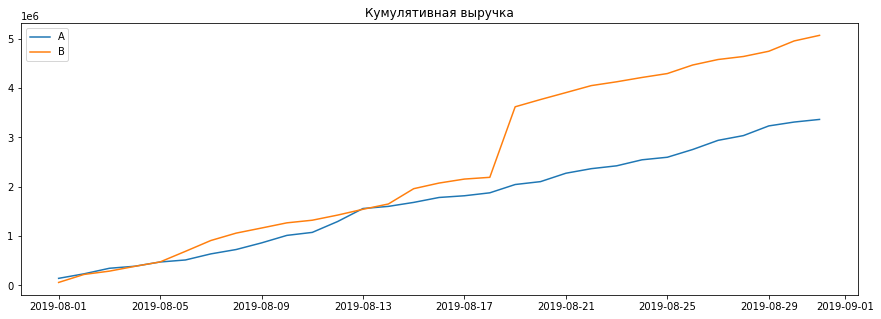

In [13]:
 # построим графики
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(orders_agg_a.date, orders_agg_a.revenue, label = 'A')
ax.plot(orders_agg_b.date, orders_agg_b.revenue, label = 'B')
plt.legend()
plt.title('Кумулятивная выручка')
plt.show()

 Выручка в обеих группах увеличивается на протяжении всего теста. Однако в группе B есть резкий всплеск, который может свидетельствовать о всплеске числа заказов или о появлении неожидано дорогих заказов.

## Кумулятивный средний чек
Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов

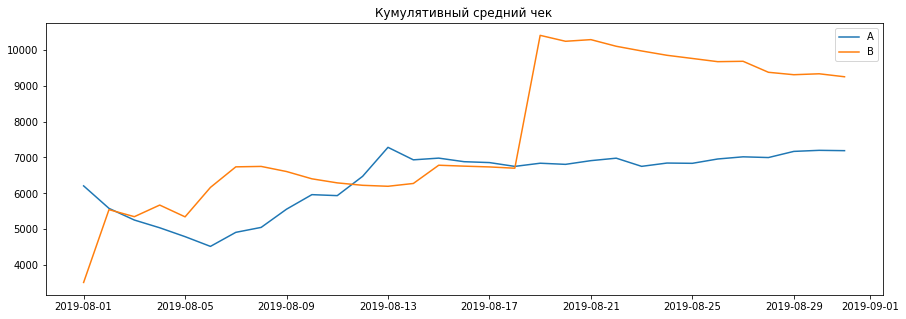

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(orders_agg_a.date, orders_agg_a.revenue / orders_agg_a.transaction_id, label = 'A')
ax.plot(orders_agg_b.date, orders_agg_b.revenue / orders_agg_b.transaction_id, label = 'B')
plt.legend()
plt.title('Кумулятивный средний чек')
plt.show()

 Средний чек в группе A за первые две недели подрос и стабилизировался, а в группе B резко подскочил и стал плавно снижаться к концу теста. Вероятно, в группу B попали какие-то крупные заказы, судя по резкому всплеску на графике.

 ## Отношение средних чеков

In [15]:
 # собираем общую таблицу
orders_agg = orders_agg_a.merge(orders_agg_b, on='date', how='left', suffixes=('_A', '_B'))
orders_agg['rel_rev'] = (
    (orders_agg.revenue_B  / orders_agg.transaction_id_B ) 
    / (orders_agg.revenue_A  / orders_agg.transaction_id_A ) - 1
)


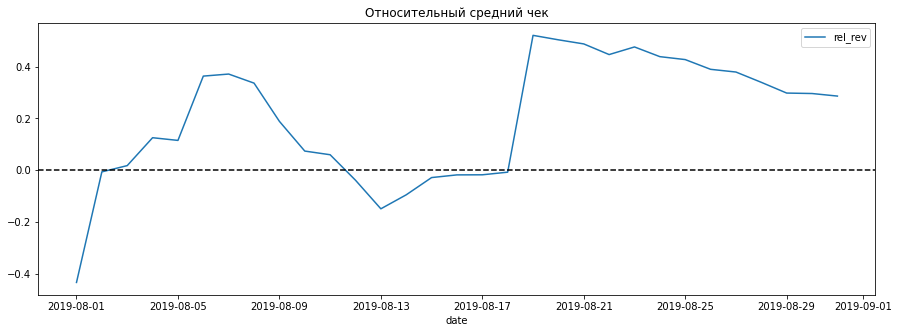

In [16]:
 # строим график
orders_agg.plot('date', 'rel_rev', figsize=(15, 5))
plt.title('Относительный средний чек')
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

 Скачок около 19 августа продолжает сохраняться. В этот момент наверняка случился какой-то экстремально крупный заказ.

 ## Кумулятивная конверсия

In [17]:
#добавляем данные о посетителях
orders_agg_a['vis_agg_a'] = visitors[visitors['group'] == 'A']['visitors'].reset_index(drop=True).cumsum(axis=0)
orders_agg_b['vis_agg_b'] = visitors[visitors['group'] == 'B']['visitors'].reset_index(drop=True).cumsum(axis=0)

In [18]:
# считаем конверсию
orders_agg_a['conversion_A'] = orders_agg_a.transaction_id / orders_agg_a.vis_agg_a
orders_agg_b['conversion_B'] = orders_agg_b.transaction_id / orders_agg_b.vis_agg_b

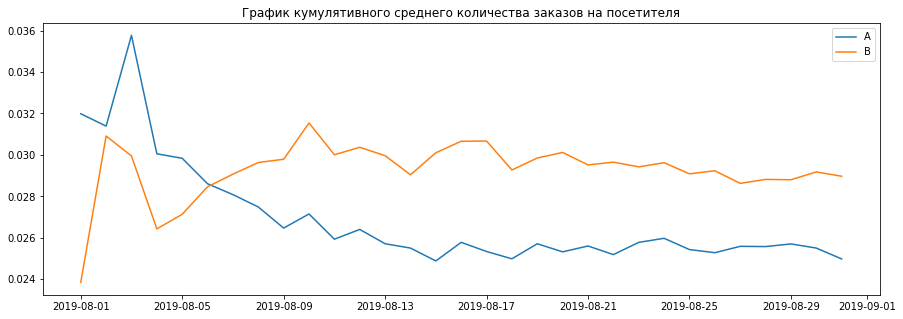

In [19]:
# строим график
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(orders_agg_a.date, orders_agg_a['conversion_A'], label = 'A')
ax.plot(orders_agg_b.date, orders_agg_b['conversion_B'], label = 'B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя')
plt.show()

Группы стартовали с очень разных значений, но затем группа A постепенно просела, а группа B стабилизировалась - причем стабильно выше группы A.

 ## Относительная конверсия

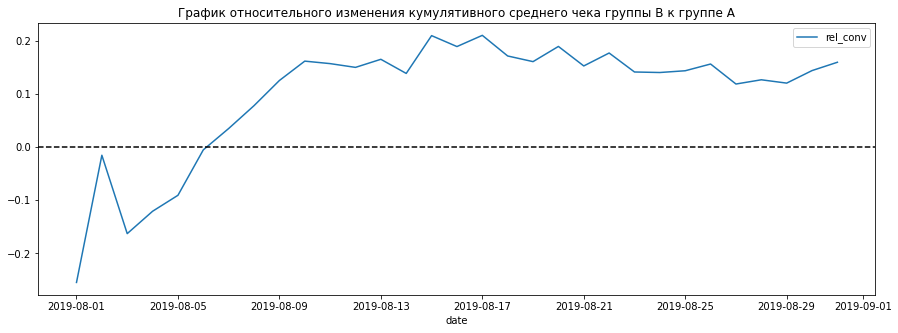

In [20]:
 orders_agg['rel_conv'] = orders_agg_b['conversion_B'] / orders_agg_a['conversion_A'] - 1
# строим график
orders_agg.plot('date', 'rel_conv', figsize=(15, 5))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

 В целом отношение конверсий стабилизировалось - причем группа A проигрывает группе B на протяжении почти всего теста.  
 
## Вывод

Анализ графиков кумулятивных метрик (среднего чека, конверсии) позволяет предположить, что среди заказов в группе B есть экстремально большие, которые сильно влияют на прирост среднего чека. Конверсия в группах к концу теста стабилизировалась, причем в группе A она выше.

 ## Анализ выбросов Распределение заказов по пользователям
Подсчитаем количество заказов по пользователям.

In [21]:
 orders_by_user = orders_good.groupby('visitor_id')['transaction_id'].nunique()
orders_by_user.sort_values(ascending=False).head(10)

visitor_id
3967698036    3
249864742     3
2108163459    3
2988190573    3
3908431265    3
611059232     3
2742574263    3
678354126     2
1404560065    2
1985475298    2
Name: transaction_id, dtype: int64

 Построим точечную диаграмму числа заказов на одного пользователя

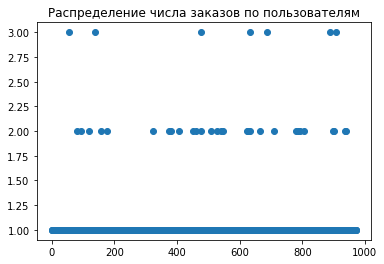

In [22]:
plt.scatter(pd.Series(range(0,len(orders_by_user))), orders_by_user)
plt.title('Распределение числа заказов по пользователям')
plt.show()

 Большинство пользователей сделали 1 заказ, некоторые - 2, и всего 7 человек - 3 заказа.  
 
 ## Посчитаем выборочные перцентили количества заказов на одного пользователя

In [23]:
# доля пользователей с более чем 1 заказом
print('{:.2%}'.format(len(orders_by_user[orders_by_user > 1]) / len(orders_by_user)))

3.70%


 Менее 4% пользователей оформили больше 1 заказа. Следует отсеять как аномальных пользователей с 2 и 3 заказами.  

 ## Распределение стоимостей заказов
Посмотрим на информацию о стоимостях заказов

In [24]:
orders_good['revenue'].describe(percentiles=[0.05, 0.50, 0.90, 0.95, 0.99])

count    1.016000e+03
mean     8.300815e+03
std      4.212199e+04
min      5.000000e+01
5%       3.000000e+02
50%      2.955000e+03
90%      1.799000e+04
95%      2.678500e+04
99%      5.390400e+04
max      1.294500e+06
Name: revenue, dtype: float64

 95-й и 99-й перцентили стоимости заказов - 26785 и 53904 рубля соответственно. 
 
 Построим точечную диаграмму распределения стоимостей заказов

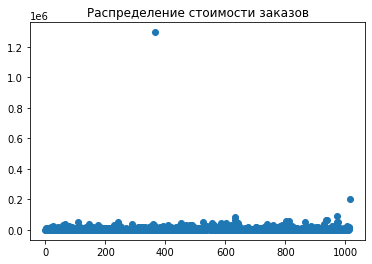

In [25]:
plt.scatter(pd.Series(range(0,len(orders_good))), orders_good['revenue'])
plt.title('Распределение стоимости заказов')
plt.show()

In [26]:
# доля заказов дороже, чем 27000
print('{:.2%}'.format(len(orders_good[orders_good.revenue > 27000]) / len(orders_good)))

5.02%


 Примерно чем 5% заказов дороже, чем 26785 рублей, и есть один выброс - заказ стоимостью почти 1,3 миллиона! Скорее всего, именно он причина скачка на графиках. Кроме того, как аномальные можно отсеять заказы стоимостью выше 27000 рублей.

 ## Статистический анализ
 
В предыдущих разделах проекта мы изучали результаты A/B теста. Общий вывод - в данных есть выбросы, аномальные значения.

В данном разделе проверим, как влияют и влияют ли вообще эти выбросы на конверсию в группах.

Начнем с расчета статистической значимости по сырым данным - т.е. по тем, из которых мы не удаляли аномальные значения.

Сформулируем нулевую и альтернативную гипотезы:

**H0 - между группами нет различий в среднем количестве заказов**

**H1 - между группами есть различия в среднем количестве заказов**

Начнем с подготовки данных. Как известно, данные о продажах и средних редко бывают распределены нормально, поэтому, для проверки гипотез воспользуемся непараметрическим тестом Уилкоксона-Манна-Уитни.

Уровень значимости установим как 0.05

In [27]:
 # таблица со сгруппированными по дня и группам заказами
orders_date = orders_good.groupby(['date', 'group']).agg({'transaction_id' : 'nunique', 
                                       'visitor_id' : 'nunique', 
                                       'revenue' : 'sum'}).sort_values(by=['date','group']).reset_index()
orders_date.head(5)

,date,group,transaction_id,visitor_id,revenue
0,2019-08-01,A,23,19,142779
1,2019-08-01,B,17,17,59758
2,2019-08-02,A,19,18,91602
3,2019-08-02,B,23,22,162043
4,2019-08-03,A,24,24,112473


In [28]:
 # по группе A

data_a = orders_agg_a[['date', 'transaction_id', 'revenue', 'vis_agg_a']].merge(orders_date[orders_date['group']=='A']
                                                                                [['date', 'transaction_id', 'revenue']], 
                  on='date', how='left')

data_a = data_a.merge(visitors[visitors['group'] == 'A'][['date', 'visitors']], on='date', how='left')

data_a.set_axis(['date', 'orders_agg', 'revenue_agg', 'visiters_agg', 'orders_daily', 'revenue_daily', 'visitors_daily'], 
                axis='columns', inplace=True)

In [29]:
 # по группе B
data_b = orders_agg_b[['date', 'transaction_id', 'revenue', 'vis_agg_b']].merge(orders_date[orders_date['group']=='B']
                                                                                [['date', 'transaction_id', 'revenue']], 
                  on='date', how='left')


data_b = data_b.merge(visitors[visitors['group'] == 'B'][['date', 'visitors']], on='date', how='left')

data_b.set_axis(['date', 'orders_agg', 'revenue_agg', 'visiters_agg', 'orders_daily', 'revenue_daily', 'visitors_daily'], 
                axis='columns', inplace=True)

In [30]:
# создание списков для анализа конверсии
order_users_A = (
    orders_good[orders_good['group'] == 'A'].groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

order_users_B = (
    orders_good[orders_good['group'] == 'B'].groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

sample_A = pd.concat([order_users_A['transaction_id'], 
                     pd.Series(0,index=np.arange(data_a['visitors_daily'].sum() - len(order_users_A['transaction_id'])), 
                               name='orders')], axis=0)

sample_B = pd.concat([order_users_B['transaction_id'], 
                     pd.Series(0,index=np.arange(data_b['visitors_daily'].sum() - len(order_users_B['transaction_id'])), 
                               name='orders')], axis=0)

In [31]:
alpha = .05 
results = stats.mannwhitneyu(sample_A, sample_B)


print('p-value: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

print('относительный выигрыш группы B:', "{0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

p-value:  0.011
Отвергаем нулевую гипотезу
относительный выигрыш группы B: 0.160


Анализируя различия в количестве заказов между группами мы видим, что нулевая гипотеза отвергнута p-value = 0.011 что меньше 0,05, т.е. между группами есть разница в количестве заказов. Относительный выигрыш группы B - 0.16, т.е. группа B получила на 16% больше заказов на посетителя

In [32]:
print("{0:.3f}".format(st.mannwhitneyu(sample_A, sample_B, alternative="two-sided")[1]))

0.011


 С применением двусторонней проверки p-value в два раза больше, но все еще меньше 0.05  
 
 Найдём относительные различия в среднем чеке между группами: 
 
 **Нулевая гипотеза H0 - статистически значимых различий в среднем чеке между группами нет.**
 
 **Гипотеза H1 - статистически значимые различия есть.**

In [33]:
alpha = .05 
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])


print('p-значение: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

print('относительный выигрыш группы B:', "{0:.3f}".format(
    orders[orders['group']=='B']['revenue']
    .mean()/orders[orders['group']=='A']['revenue']
    .mean()-1)
     )   

p-значение:  0.729
Не получилось отвергнуть нулевую гипотезу
относительный выигрыш группы B: 0.259


Анализируя "сырые" данные мы видим, что нулевую гипотезу не получилось опровергнуть, между группами нет разницы. 

При этом относительный выигрыш группы B составил 25.9%

 ## Анализ на данных без выбросов
 
Ранее мы приняли за аномальных пользователей тех, кто совершил более 1 заказа или совершил заказ дороже 27000 рублей.

Узнаем, сколько всего аномальных пользователей.

In [34]:
# пользователи с несколькими заказами

mult_orders = orders_good.groupby('visitor_id')['transaction_id'].count().reset_index()
mult_orders = mult_orders[mult_orders['transaction_id'] > 1]['visitor_id']

# пользователи с дорогими заказами

expensive_orders = orders_good[orders_good['revenue'] > 27000]['visitor_id'].reset_index(drop=True)

abnormal_users = pd.Series((list(mult_orders) + list(expensive_orders)), name='visitors_id').drop_duplicates()
print(abnormal_users.head())
len(abnormal_users)

0    249864742
1    366673373
2    406208401
3    522292794
4    611059232
Name: visitors_id, dtype: int64


86

 Всего таких пользователей 86.
 
 Узнаем, как их действия повлияли на результаты теста. 
 
 Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. 
 
 Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [35]:
sample_A_filt = pd.concat([order_users_A.query('not visitor_id in @abnormal_users')['transaction_id'], 
                          pd.Series(0, index=np.arange(data_a['visitors_daily'].sum() - len(order_users_A['transaction_id'])), 
                                    name='orders')], axis=0)
sample_B_filt = pd.concat([order_users_B.query('not visitor_id in @abnormal_users')['transaction_id'], 
                          pd.Series(0, index=np.arange(data_b['visitors_daily'].sum() - len(order_users_B['transaction_id'])), 
                                    name='orders')], axis=0)

Применим статистический критерий Манна-Уитни к полученным выборкам:

Гипотезы:

**H0 - между группами нет различий в среднем количестве заказов**

**H1 - между группами есть различий в среднем количестве заказов**

In [36]:
alpha = .05 
results = stats.mannwhitneyu(sample_A_filt, sample_B_filt)


print('p-значение: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

print('относительный выигрыш группы B:', "{0:.3f}".format(sample_B_filt.mean()/sample_A_filt.mean()-1))

p-значение:  0.016
Отвергаем нулевую гипотезу
относительный выигрыш группы B: 0.174



По "очищенным" данным различия между группами A и B также есть: 
 p-value заметно меньше 0.05, и нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов между группами нет, следует отвергнуть. 
 
 Относительный выигрыш группы B увеличился и равен 17,4%. 
 
 Проверим, как изменились результаты по среднему чеку.
 


In [37]:
 print('{0:.3f}'.format(st.mannwhitneyu(orders_good.query('group == "A" and not visitor_id in @abnormal_users')['revenue'], 
                                      orders_good.query('group == "B" and not visitor_id in @abnormal_users')['revenue'])[1]))

print('{0:.3f}'.format(orders_good.query('group == "B" and not visitor_id in @abnormal_users')['revenue'].mean() / 
                       orders_good.query('group == "A" and not visitor_id in @abnormal_users')['revenue'].mean() - 1))

0.727
-0.034


P-value уменьшился, но остался значительно больше 0.05. 

Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, по-прежнему нет.

А вот средний чек группы B без выбросов стал ниже среднего чека группы A, хотя и ненамного.

In [38]:
 # отфильтруем из списка заказов заказы "аномальных" пользователей
orders_super_good = orders_good.query('not visitor_id in @abnormal_users')
# составим сводную кумулятивную таблицу
o_pivot = orders_super_good.pivot_table(index='date', columns='group', 
                                        aggfunc={'transaction_id': 'nunique','revenue': 'sum'}).sort_index()
o_pivot = o_pivot.cumsum().reset_index()
o_pivot['rel_rev'] = (
    (o_pivot[('revenue', 'B')]  / o_pivot[('transaction_id', 'B')] ) 
    / (o_pivot[('revenue', 'A')]  / o_pivot[('transaction_id', 'A')] ) - 1
)

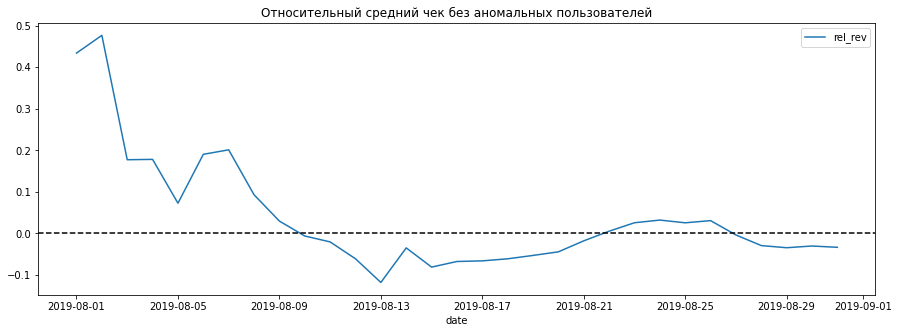

In [39]:
 # построим график
o_pivot.plot('date', 'rel_rev', figsize=(15, 5))
plt.title('Относительный средний чек без аномальных пользователей')
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

 # Выводы
 
1. Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.

2. Как по сырым, так и по данным без аномалий нет статистически значимого различия по среднему чеку между группами. 

3. График различия конверсии между группами показывает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.

4. График различия среднего чека до фильтрации аномалий колеблется: именно благодаря ему мы нашли аномалии. Сделать из этого графика определённые выводы нельзя.

5. График различия среднего чека после фильтрации постепенно стабилизировался около 0 - значимых различий между средними чеками в разных группах нет. 

В целом тест можно остановить. Мы увидели прирост конверсии в группе B, но на среднем чеке проверяемая гипотеза не сказалась.

# Результаты:
    
Проведена приоритизация гипотез по фреймворкам ICE и RICE.

Проведен анализ результатов A/B-теста, построены графики кумулятивной выручки, среднего чека, конверсии по группам. Выявлены аномальные заказы и пользователи, добавшие шум и искажения в данные теста.

Рассчитана статистическая значимость различий конверсий и средних чеков по сырым и очищенным данным:  значимых различий между средними чеками в разных группах нет.

На основании анализа принято решение о нецелесообразности дальнейшего проведения теста.

 по ссылкам ниже интересные материалы по А/В тестам
  
    
https://habr.com/ru/company/avito/blog/571094/

https://habr.com/ru/company/yandex/blog/476826/

https://academy.yandex.ru/journal/kak-provesti-a-b-testirovanie-6-prostykh-shagov

https://habr.com/ru/company/yandex/blog/342704/

https://r-analytics.blogspot.com/2013/10/blog-post_13.html 
